# Spark Clustering

## Initializing Spark and tables

In [1]:
import findspark
findspark.init()

from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local').appName('hotels').getOrCreate()

sc = spark.sparkContext 

In [2]:
rdd = spark.read.csv('./Hotels_Good_Data.csv',header=True).rdd

 ### 150 Hotels with highest number of records

In [3]:
top150 = rdd.map(lambda x: (x['Hotel Name'], 1)).reduceByKey(lambda x , y: x+y).sortBy(lambda x: x[1], ascending = False).map(lambda x: (x[0], x[1])).take(150)
            
hotelNames = sc.parallelize(top150).keys().collect()
            
top150Hotels =rdd.filter(lambda x: x['Hotel Name'] in hotelNames)

for index,hotel in enumerate(top150):
    print (index+1, hotel[0],hotel[1])

1 Newark Liberty International Airport Marriott 5240
2 Hilton Garden Inn Times Square 4760
3 Residence Inn Newark Elizabeth Liberty International Airport 4235
4 Westin New York at Times Square 3714
5 Loews Regency New York Hotel 3519
6 Viceroy New York 3493
7 Four Seasons Hotel New York 3171
8 Langham Place New York Fifth Avenue 3123
9 The Carlyle A Rosewood Hotel 3022
10 Magnuson Convention Center Hotel 2792
11 DoubleTree by Hilton Metropolitan - New York City 2782
12 Hilton Garden Inn New York West 35th Street 2743
13 Hilton Garden Inn New York-Times Square Central 2704
14 Conrad New York 2624
15 Wyndham Garden Brooklyn Sunset Park 2523
16 Hilton Newark Airport 2468
17 Omni Berkshire Place 2306
18 Hilton Times Square 2220
19 Park Hyatt New York 2179
20 Homewood Suites by Hilton NY Midtown Manhattan Times Square 2159
21 Grand Hyatt New York 2112
22 The Plaza Hotel 2100
23 Quality Inn Woodside 2099
24 Hyatt Union Square New York 2074
25 Le Parker Meridien New York 2052
26 The New York 

### 40 Checkin Dates with highest number of records

In [5]:
top40 = top150Hotels.map(lambda x: (x['Checkin Date'], 1)).reduceByKey(lambda x , y: x+y).sortBy(lambda x: x[1], ascending = False).map(lambda x: (x[0], x[1])).take(40)

checkin = sc.parallelize(top40).keys().collect()
checkin.sort()
            
finalData = top150Hotels.filter(lambda x: x['Checkin Date'] in checkin).sortBy(lambda x: x['Discount Code']).sortBy(lambda x: x['Hotel Name']).sortBy(lambda x: x['Checkin Date'])

for index,date in enumerate(top40):
    print(index+1,date[0],date[1])

1 2015-11-11 2252
2 2015-11-04 1863
3 2015-10-28 1842
4 2015-10-14 1812
5 2015-08-19 1811
6 2015-10-21 1810
7 2015-11-06 1785
8 2015-08-12 1733
9 2015-11-05 1673
10 2015-10-22 1638
11 2015-11-12 1627
12 2015-09-10 1601
13 2015-10-29 1598
14 2015-09-09 1574
15 2015-11-18 1541
16 2015-11-10 1529
17 2015-11-13 1527
18 2015-08-26 1519
19 2015-10-15 1425
20 2015-11-21 1413
21 2015-09-16 1399
22 2015-10-30 1379
23 2015-09-30 1373
24 2015-09-17 1368
25 2015-11-28 1344
26 2015-11-26 1335
27 2015-09-11 1310
28 2015-10-01 1286
29 2015-09-18 1284
30 2015-11-27 1280
31 2015-10-16 1272
32 2015-11-07 1242
33 2015-10-27 1222
34 2015-10-02 1220
35 2015-08-27 1217
36 2015-08-28 1216
37 2015-10-07 1205
38 2015-11-03 1200
39 2015-08-13 1181
40 2015-11-25 1158


### Creating a table with -1 values for Hotel Name,Checkin Date & discount code.

In [6]:
allCombinations = sc.parallelize(hotelNames).cartesian(sc.parallelize(checkin).cartesian(sc.parallelize(['1','2','3','4']))).map(lambda x: (x[0], x[1][0], x[1][1])).map(lambda x: (x, -1))

In [7]:
allCombinations

PythonRDD[62] at RDD at PythonRDD.scala:52

### Creating discount prices table for a given hotel, checkin date and discount code.

In [8]:
mapData = finalData.map(lambda x: ((x['Hotel Name'],x['Checkin Date'],x['Discount Code']), float(x['Discount Price'])))

In [9]:
mapData.collect()

### Union on both previous tables

In [10]:
def reduceByHotelNChackin(x,y):
    if x == -1:
        return y
    elif y == -1:
        return x
    else:
        return min(x,y)

In [11]:
margeData = sc.union([allCombinations, mapData]).reduceByKey(reduceByHotelNChackin)
mapMarge = margeData.map(lambda x: (x[0][0], x[1])).groupByKey().mapValues(list)

In [12]:
mapMarge.collect()

### Final Table

In [13]:
import pandas as pd
columns=['Hotel Name']
for i in range(1,161):
    columns.append(i)
df = pd.DataFrame(mapMarge.map(lambda x: [x[0]] + x[1]).take(150), columns=columns)
df

,Hotel Name,1,2,3,4,5,6,7,8,9,...,151,152,153,154,155,156,157,158,159,160
0,DoubleTree by Hilton New York City - Chelsea,-1.000000,7.262629,-1.000000,7.361375,6.946976,7.474205,7.113956,7.149132,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,7.029088,-1.000000,7.105786,-1.000000,7.113142,-1.000000
1,DoubleTree by Hilton Hotel Newark Airport,-1.000000,-1.000000,-1.000000,-1.000000,6.840547,-1.000000,-1.000000,-1.000000,6.613384,...,6.727432,-1.000000,-1.000000,6.626718,-1.000000,-1.000000,6.572283,6.626718,-1.000000,6.626718
2,Hilton Garden Inn New York Long Island City,-1.000000,-1.000000,7.157735,-1.000000,6.516193,-1.000000,6.629363,-1.000000,-1.000000,...,6.668228,7.326466,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3,Courtyard by Marriott New York Manhattan Cen...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,Dumont NYC-an Affinia hotel,-1.000000,-1.000000,7.409742,-1.000000,-1.000000,-1.000000,-1.000000,7.190676,7.278629,...,7.507690,-1.000000,-1.000000,7.549083,-1.000000,-1.000000,7.377759,-1.000000,-1.000000,-1.000000
5,Four Seasons Hotel New York,-1.000000,-1.000000,8.595080,8.563122,8.589514,-1.000000,8.585786,8.524169,8.516193,...,-1.000000,-1.000000,-1.000000,-1.000000,8.512181,8.631414,8.491875,8.428362,8.491875,8.585786
6,Omni Berkshire Place,7.297768,-1.000000,7.546974,6.965080,7.470224,7.423568,7.699389,7.567863,7.356280,...,7.656810,7.180070,7.652071,7.461066,7.619233,7.603399,-1.000000,7.583248,7.851272,7.655864
7,Hampton Inn Manhattan Downtown-Financial District,7.323831,6.980076,6.836259,6.800170,6.822197,-1.000000,-1.000000,7.127694,-1.000000,...,-1.000000,7.278629,-1.000000,-1.000000,-1.000000,-1.000000,7.134891,6.982863,7.029088,7.204149
8,Millenium Hilton,7.349231,-1.000000,-1.000000,-1.000000,-1.000000,6.932448,-1.000000,6.980076,7.567863,...,-1.000000,7.043160,-1.000000,7.509335,6.980076,7.492760,-1.000000,7.368340,-1.000000,7.196687
9,TRYP By Wyndham Times Square South,7.198184,-1.000000,6.967909,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


### Normalizing the hotel prices between 0 to 100

In [14]:
def change_range(OldValue,OldMax,OldMin,NewMax,NewMin):
    return (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin

In [15]:
def norm(row):
    filtered_prices = list(filter(lambda x: x != -1, row[1]))
    if len(filtered_prices) == 0:
        return row
    
    maximum = max(filtered_prices)
    minimum = min(filtered_prices)
    if (maximum==minimum):
        maximum=maximum+1
    
    array = []
    for price in row[1]:
        if price == -1:
            array.append(price)
        else:
            array.append(change_range(price,maximum,minimum,100,0))
    return (row[0],array)

In [16]:
normData = mapMarge.map(norm)
normPrices = normData.values()

df = pd.DataFrame(normData.map(lambda x: [x[0]] + x[1]).take(150), columns=columns)
df

,Hotel Name,1,2,3,4,5,6,7,8,9,...,151,152,153,154,155,156,157,158,159,160
0,DoubleTree by Hilton New York City - Chelsea,-1.000000,68.547394,-1.000000,78.553704,36.561377,89.987041,53.481969,57.046406,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,44.881986,-1.000000,52.654080,-1.000000,53.399483,-1.000000
1,DoubleTree by Hilton Hotel Newark Airport,-1.000000,-1.000000,-1.000000,-1.000000,63.867708,-1.000000,-1.000000,-1.000000,33.484930,...,48.738693,-1.000000,-1.000000,35.268279,-1.000000,-1.000000,27.987614,35.268279,-1.000000,35.268279
2,Hilton Garden Inn New York Long Island City,-1.000000,-1.000000,69.321680,-1.000000,10.866821,-1.000000,21.178449,-1.000000,-1.000000,...,24.719677,84.695716,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3,Courtyard by Marriott New York Manhattan Cen...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,Dumont NYC-an Affinia hotel,-1.000000,-1.000000,67.504874,-1.000000,-1.000000,-1.000000,-1.000000,28.199655,43.980331,...,85.078910,-1.000000,-1.000000,92.505654,-1.000000,-1.000000,61.766416,-1.000000,-1.000000,-1.000000
5,Four Seasons Hotel New York,-1.000000,-1.000000,67.075644,63.361333,66.428743,-1.000000,65.995467,58.833938,57.906904,...,-1.000000,-1.000000,-1.000000,-1.000000,57.440600,71.298676,55.080596,47.698676,55.080596,65.995467
6,Omni Berkshire Place,32.527691,-1.000000,56.893138,0.000000,49.389110,44.827472,71.795143,58.935455,38.248509,...,67.632063,21.020038,67.168685,48.493650,63.958102,62.409966,-1.000000,60.439675,86.645066,67.539563
7,Hampton Inn Manhattan Downtown-Financial District,82.118606,41.547911,24.574345,20.315016,22.914730,-1.000000,-1.000000,58.970091,-1.000000,...,-1.000000,76.783808,-1.000000,-1.000000,-1.000000,-1.000000,59.819516,41.876817,47.332374,67.993553
8,Millenium Hilton,53.423937,-1.000000,-1.000000,-1.000000,-1.000000,3.554331,-1.000000,9.253201,79.584031,...,-1.000000,16.801430,-1.000000,72.581020,9.253201,70.597765,-1.000000,55.710382,-1.000000,35.171458
9,TRYP By Wyndham Times Square South,73.270730,-1.000000,28.910961,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


In [44]:
df.to_csv('Kmeans_data.csv',encoding='UTF-8')

### Hierarchical distributed Kmeans

In [69]:
from numpy import array

from pyspark.ml.clustering import BisectingKMeans, BisectingKMeansModel
from pyspark.ml.feature import VectorAssembler

data = spark.read.csv('./Kmeans_data.csv',header=True,inferSchema=True)
cols = data.columns
cols.pop(0)
cols.pop(0)
v_assembler = VectorAssembler(inputCols = cols, outputCol='features')
data = v_assembler.transform(data)
bkm = BisectingKMeans()

# Build the model (cluster the data)
model = bkm.fit(data)

# Evaluate clustering
cost = model.computeCost(data)
print("Bisecting K-means Cost = " + str(cost))

Bisecting K-means Cost = 17313500.5432348


### Bisecting K-means for different k's number

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

k_range = range(2,40)
costs=[]
for numK in k_range:
    bkm = BisectingKMeans(k=numK)
    model = bkm.fit(data)
    cost = model.computeCost(data)
    costs.append(cost)

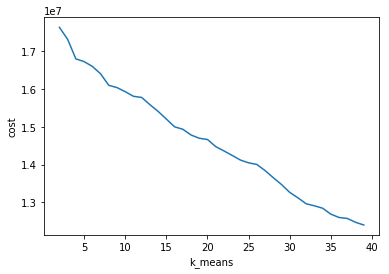

In [63]:
plt.plot(k_range,costs)
plt.xlabel('k_means')
plt.ylabel('cost')

<blockquote>
    <h4>Kmeans with k's from 1 to 40</h4>
    <p>
    We can see from the graph above that for every 'k' we add the error is reduced,
    we believe that the reason for that is that the centers addition causes an error reduction because that the data is very distributed and unordered, and as we add centers the rest of the observations are getting closer and reduces the error.
    We keep investigate.
    </p>
</blockquote>

In [67]:
k_range = range(40,80)
costs=[]
for numK in k_range:
    bkm = BisectingKMeans(k=numK)
    model = bkm.fit(data)
    cost = model.computeCost(data)
    costs.append(cost)

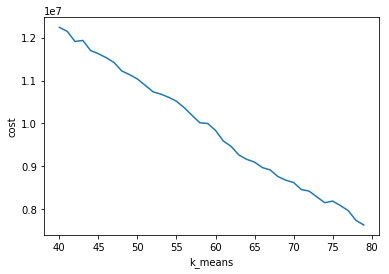

In [68]:
plt.plot(k_range,costs)
#plt.title('Graph 2.3 - Multiple trees with different depths')
plt.xlabel('k_means')
plt.ylabel('cost')

<blockquote>
    <h4>Kmeans with k's from 40 to 80</h4>
    <p>
    In addition to what said above, we can see that the graph continue behaving the same, and goes down by 0.4, so we learn that the data is distributed.
    </p>
</blockquote>

## Clustering Algorithm and Dendrogram

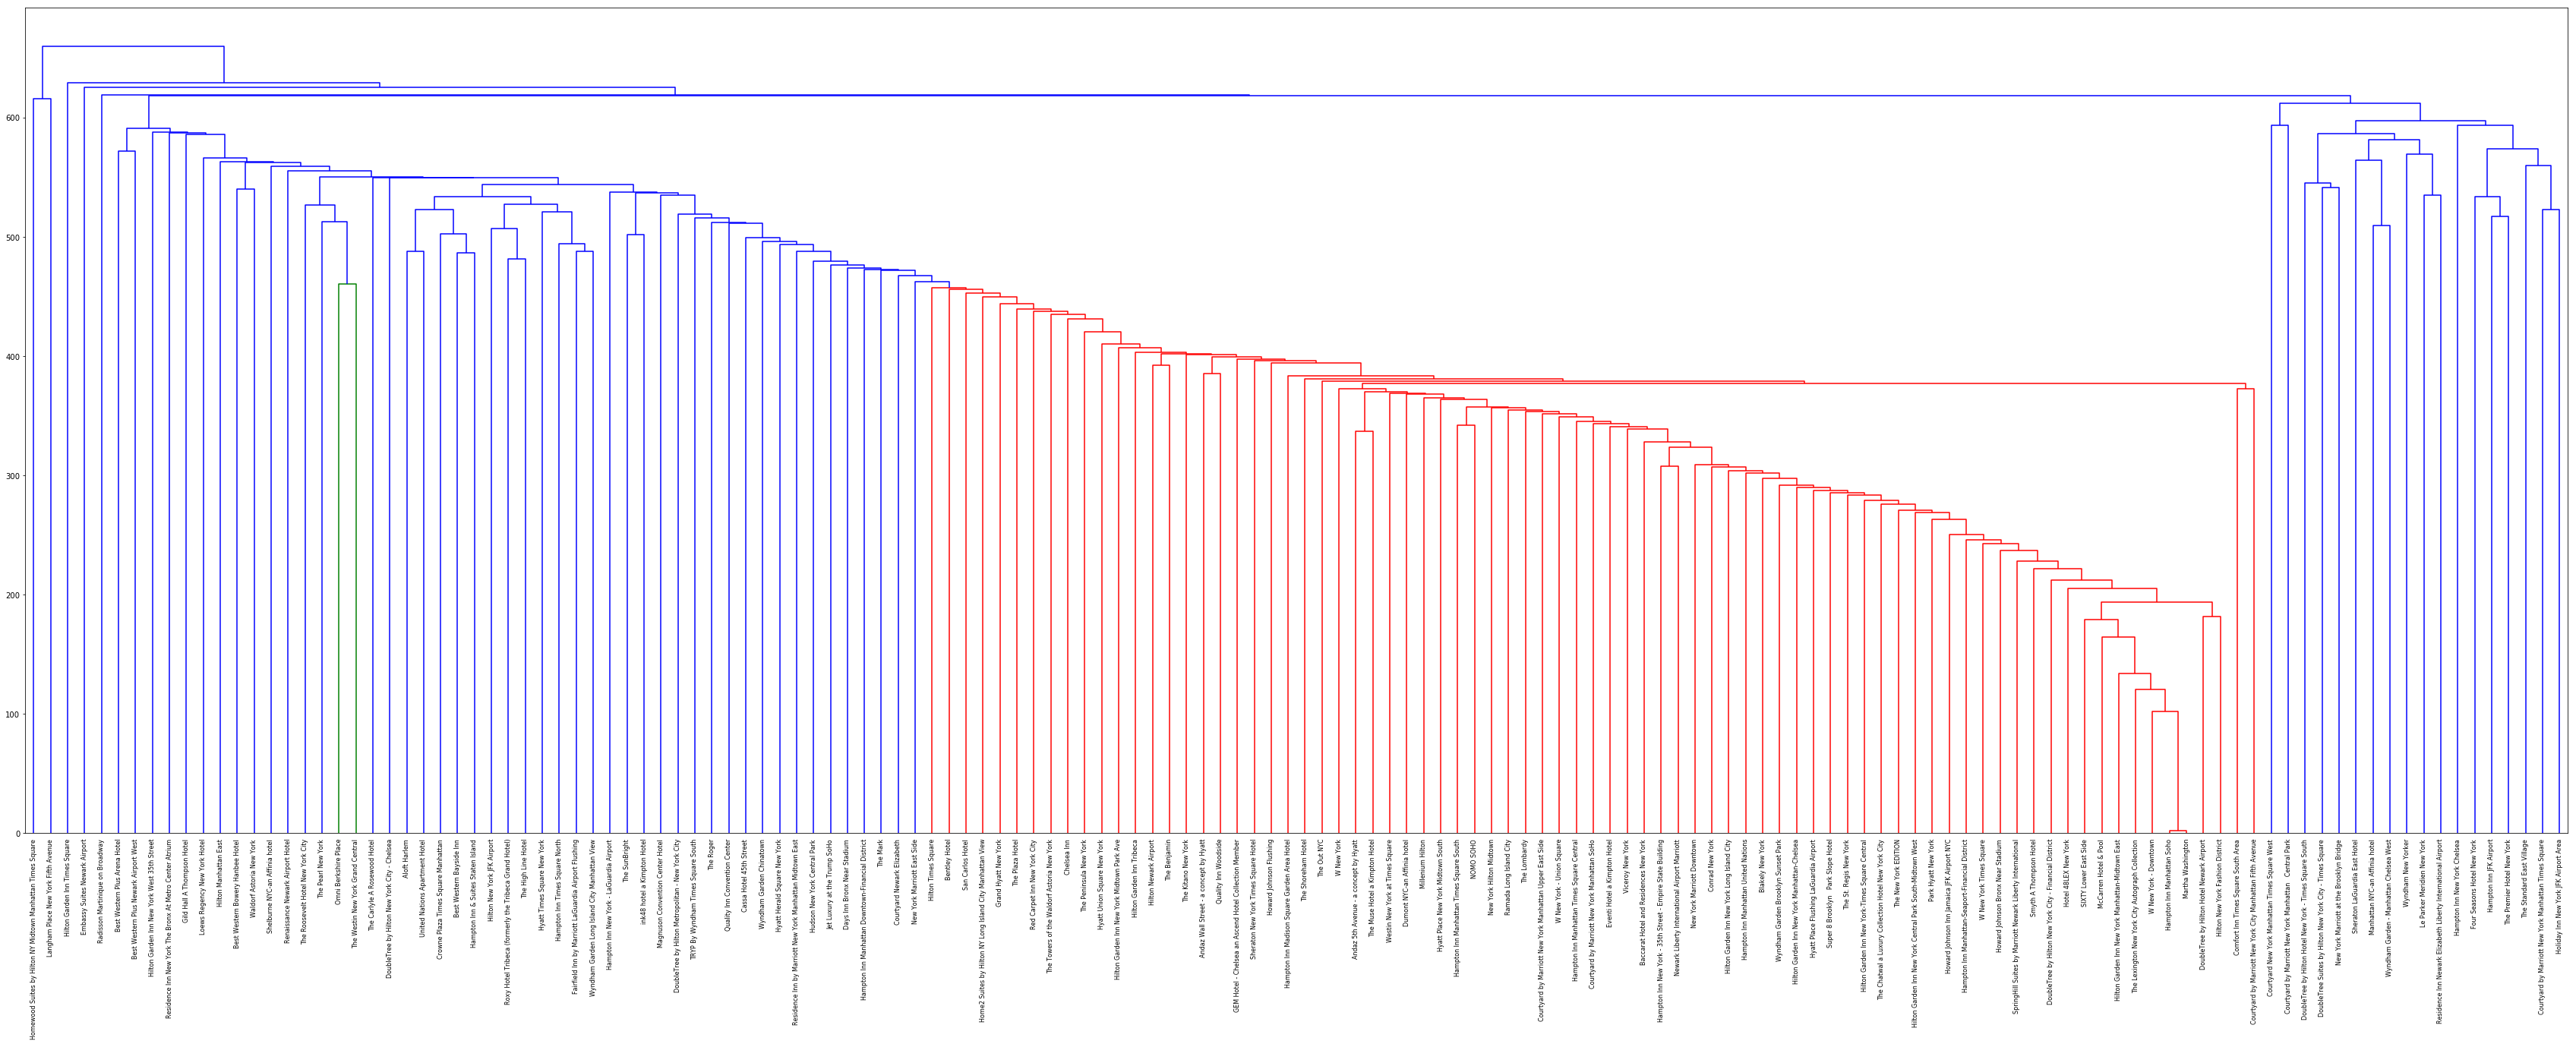

In [17]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from matplotlib import pyplot as plt

normalised_prices_data = normPrices.take(150)
average = linkage(normalised_prices_data, 'average')
plt.figure(figsize=(60, 20))
dendrogram(average,labels=normData.map(lambda x: x[0]).sortBy(lambda x: x).take(150),leaf_font_size=8,leaf_rotation=90 , p=150)
plt.show()

<blockquote>
    <h4>Dendrogram analysis</h4>
    <p>In the dendrogram above, the joined lines of the dendrogram indicates the order in which the clusters were joined.</p>
    <p>
    The heights of a splites reflect the distance between the clusters, for example we can see that hotel 'Embassy suits newark airport' and 'The perl new york' are most similar,as the height of the link that joins them together is the smallest.
    </p>
    <p>
    The dendrogram ,by ward distance method, shows us that are at least 2 clusters with a big difference between them, while The dendrogram ,by average distance method, shows us that are about 9 clusters with no big difference between them.
    </p>
    <p>
    Derived from the conclusions above we would have thought that there are two main pricing policies, but the ward ratings as we can see were low, so to conclude the average gave us better ratings so we can assume that there is for about 9 big different pricing policies.
    </p>
</blockquote>